In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load Data (wide format)
df = pd.read_stata('/Users/edmundoarias/Downloads/Control_Synth_emb.dta')

In [3]:
# Identify the columns related to country-specific variables
value_vars = ['_m', '_x', '_ov', '_tpm', '_pi', '_tc', '_emb']
intervention_vars = ['Date', 'Type', 'Purchases', 'Sales', 'Intervention', 'tipo']

In [4]:
# Extract columns with country-specific variables
country_columns = [col for col in df.columns if any(var in col for var in value_vars)]

# Create a new DataFrame with only the country-specific variables and intervention-related variables
country_df = df[country_columns + intervention_vars]

In [5]:
# Melt the DataFrame to long format
melted_df = pd.melt(country_df, id_vars=intervention_vars, var_name='country_variable', value_name='value')

# Extract country and variable type from the melted DataFrame
melted_df['country'] = melted_df['country_variable'].str.extract(r'([A-Z]+)')[0]
melted_df['variable'] = melted_df['country_variable'].str.extract(r'(_[a-z]+)')[0]
melted_df = melted_df.drop(columns=['country_variable'])


In [6]:
# Pivot the DataFrame to get the desired long format
long_df = melted_df.pivot_table(index=intervention_vars + ['country'], columns='variable', values='value', aggfunc='first').reset_index()

# Flatten the MultiIndex columns and preserve variable names
long_df.columns = [col[0] if col[1] == '' else col[1][1:] for col in long_df.columns]


In [7]:
# Define the new column names
new_columns = ['Date', 'Type', 'Purchases', 'Sales', 'Intervention', 'tipo', 'country', 'm', 'x', 'ov', 'tpm', 'pi', 'tc', 'emb']

# Assign the new column names to the DataFrame
long_df.columns = new_columns

In [8]:
# Make all interventions value zero if country is not COL
long_df.loc[long_df['country'] != 'COL', 'Intervention'] = 0

# Same for the rest of the intervention-indicating variables
long_df.loc[long_df['country'] != 'COL', 'Purchases'] = 0

# Same for the rest of the intervention-indicating variables
long_df.loc[long_df['country'] != 'COL', 'tipo'] = 0

# Same for the rest of the intervention-indicating variables
long_df.loc[long_df['country'] != 'COL', 'Sales'] = 0

# Same for the rest of the intervention-indicating variables
long_df.loc[long_df['country'] != 'COL', 'Type'] = 0

## Rename variables

In [9]:
# Rename variables
long_df = long_df.rename(columns={'m': 'imports', 'x': 'exports', 'ov': 'night_rate', 'tpm': 'tpm', 'pi': 'pi', 'tc': 'ExRate', 'emb': 'embi'})

In [10]:
# Switch names between Purchases and Sales
long_df['Purchases'], long_df['Sales'] = long_df['Sales'], long_df['Purchases']

In [11]:
# Store Data as csv
long_df.to_csv('/Users/edmundoarias/Documents/Uniandes/2024-10/HE 2/FX-Intervention/8._Extension Final/2._ProcessedData/Long/Panel_long.csv', index=False)

## Treatment

In [12]:
df = long_df

In [13]:
# Magnitude
df['net'] = df['Purchases'] - df['Sales']

In [14]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Extract rows where there was an intervention
interventions = colombia_data[colombia_data['Intervention'] != 0]

# Calculate the net intervention
interventions['net'] = interventions['Purchases'] - interventions['Sales']

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2987227263.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interventions['net'] = interventions['Purchases'] - interventions['Sales']


In [15]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Extract the year from the 'Date' column
colombia_data['Year'] = colombia_data['Date'].dt.year

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/270554390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/270554390.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/270554390.py:11: Settin

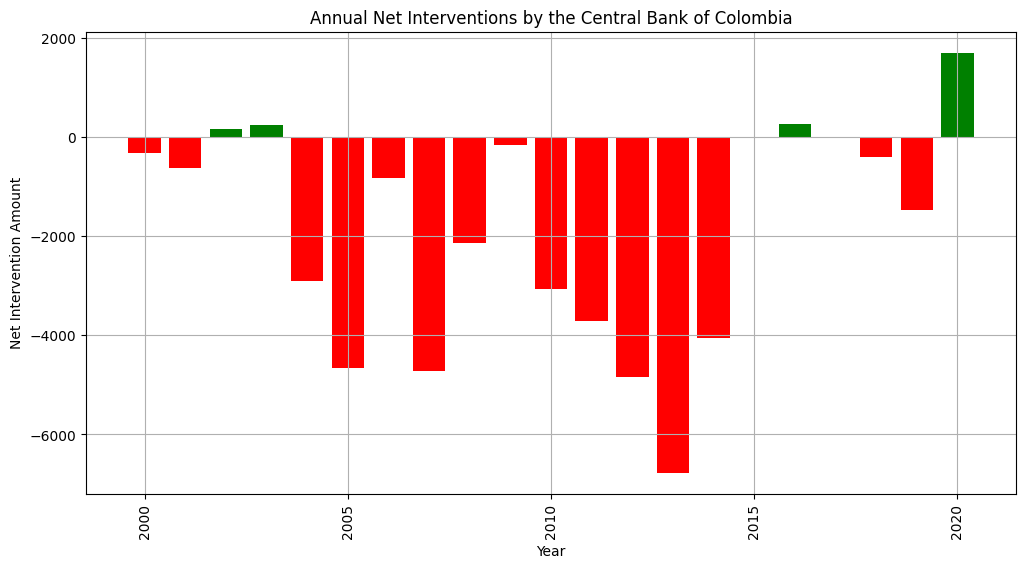

In [16]:
# Aggregate the net interventions by year
annual_interventions = colombia_data.groupby('Year')['net'].sum().reset_index()

# Plot the net interventions by year
plt.figure(figsize=(12, 6))
plt.bar(annual_interventions['Year'], annual_interventions['net'], color=annual_interventions['net'].apply(lambda x: 'green' if x > 0 else 'red'))

plt.title('Annual Net Interventions by the Central Bank of Colombia')
plt.xlabel('Year')
plt.ylabel('Net Intervention Amount')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2392860381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2392860381.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']


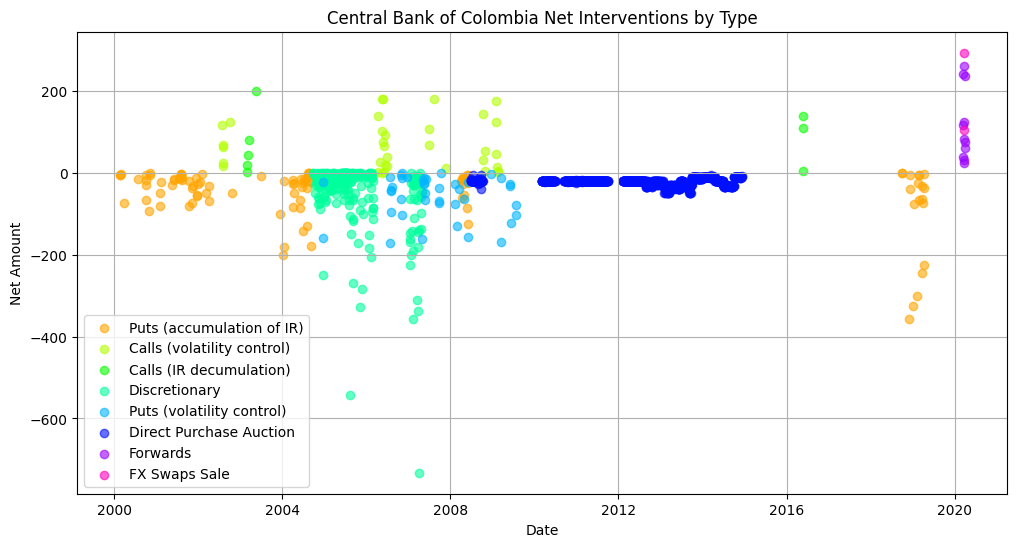

In [17]:
import seaborn as sns

# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Extract rows where there was an intervention
interventions = colombia_data[colombia_data['Intervention'] != 0]

# Set up the color palette
palette = sns.color_palette("hsv", len(interventions['Type'].unique()))

# Plot the net interventions for the entire period, colored by type
plt.figure(figsize=(12, 6))
for intervention_type, color in zip(interventions['Type'].unique(), palette):
    subset = interventions[interventions['Type'] == intervention_type]
    plt.scatter(subset['Date'], subset['net'], label=intervention_type, color=color, alpha=0.6)

plt.title('Central Bank of Colombia Net Interventions by Type')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.legend()
plt.grid(True)
plt.show()


# Defining Interventions: Using Windows

### 2-Day Intervention Window

In [42]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Sort the data by date
colombia_data = colombia_data.sort_values(by='Date')

# Define a treatment period as at least 2 consecutive days of net sales (net < 0)
colombia_data['net_negative'] = colombia_data['net'] < 0

# Create a column to mark the end of consecutive intervention periods
colombia_data['shift_net_negative'] = colombia_data['net_negative'].shift(1, fill_value=False)
colombia_data['end_of_intervention'] = (colombia_data['net_negative'] != colombia_data['shift_net_negative']) & ~colombia_data['net_negative']

# Create a column to group consecutive intervention periods
colombia_data['intervention_group'] = colombia_data['end_of_intervention'].cumsum()

# Filter to keep only groups where the intervention is for at least 2 consecutive days
intervention_counts = colombia_data.groupby('intervention_group')['net_negative'].sum()
valid_interventions = intervention_counts[intervention_counts >= 2].index

# Mark valid treatment periods
colombia_data['treatment'] = colombia_data['intervention_group'].isin(valid_interventions) & colombia_data['net_negative']

# Clean up intermediate columns
colombia_data = colombia_data.drop(columns=['net_negative', 'shift_net_negative', 'end_of_intervention', 'intervention_group'])

# Display the result
colombia_data[colombia_data['treatment']].head(20)


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2854098691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2854098691.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']


,Date,Type,Purchases,Sales,Intervention,tipo,country,imports,exports,night_rate,tpm,pi,ExRate,embi,net,treatment
4272,2000-09-29,Puts (accumulation of IR),0.0,17.1,1,5,COL,5.5000,961.583333,NaN,0.476317,-0.361166,12.00,1086.916667,-17.1,True
4294,2000-10-02,Puts (accumulation of IR),0.0,29.5,1,5,COL,5.5000,961.583333,NaN,0.915446,-0.003641,12.00,1086.916667,-29.5,True
4316,2000-10-03,Puts (accumulation of IR),0.0,65.5,1,5,COL,5.5000,961.583333,NaN,0.915446,-0.150715,12.00,1086.916667,-65.5,True
4338,2000-10-04,Puts (accumulation of IR),0.0,5.0,1,5,COL,5.5000,961.583333,NaN,0.915446,-0.625488,12.00,1086.916667,-5.0,True
4866,2000-11-07,Puts (accumulation of IR),0.0,5.0,1,5,COL,5.5000,961.583333,NaN,0.915446,-0.025232,12.00,1086.916667,-5.0,True
4888,2000-11-08,Puts (accumulation of IR),0.0,1.0,1,5,COL,5.5000,961.583333,NaN,0.915446,-0.383139,12.00,1086.916667,-1.0,True
8122,2001-06-01,Puts (accumulation of IR),0.0,16.5,1,5,COL,7.5333,1069.500000,NaN,3.074664,0.120485,11.50,1024.166667,-16.5,True
8144,2001-06-04,Puts (accumulation of IR),0.0,13.5,1,5,COL,7.5333,1069.500000,NaN,3.074664,-0.544045,11.50,1024.166667,-13.5,True
9002,2001-07-27,Puts (accumulation of IR),0.0,13.5,1,5,COL,6.2333,1069.500000,NaN,0.573262,-0.101065,9.50,1024.166667,-13.5,True
9024,2001-07-30,Puts (accumulation of IR),0.0,5.0,1,5,COL,6.2333,1069.500000,NaN,0.573262,-0.014209,9.50,1024.166667,-5.0,True


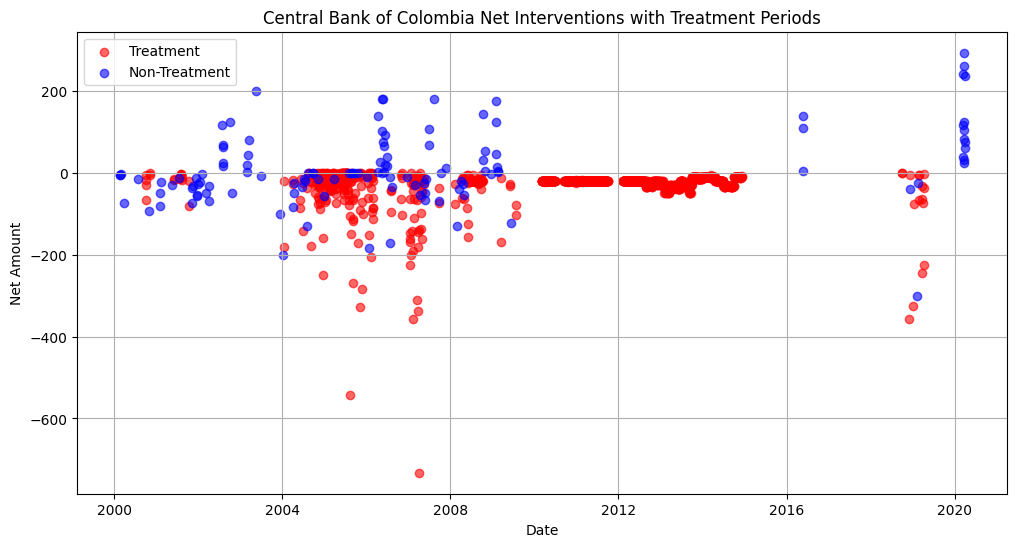

In [43]:
# Filter out rows where net intervention is zero
filtered_data = colombia_data[colombia_data['net'] != 0]

# Plot the net interventions, differentiating between treatment and non-treatment periods
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data[filtered_data['treatment']]['Date'], filtered_data[filtered_data['treatment']]['net'], label='Treatment', color='red', alpha=0.6)
plt.scatter(filtered_data[~filtered_data['treatment']]['Date'], filtered_data[~filtered_data['treatment']]['net'], label='Non-Treatment', color='blue', alpha=0.6)

plt.title('Central Bank of Colombia Net Interventions with Treatment Periods')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/3785617047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/3785617047.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']


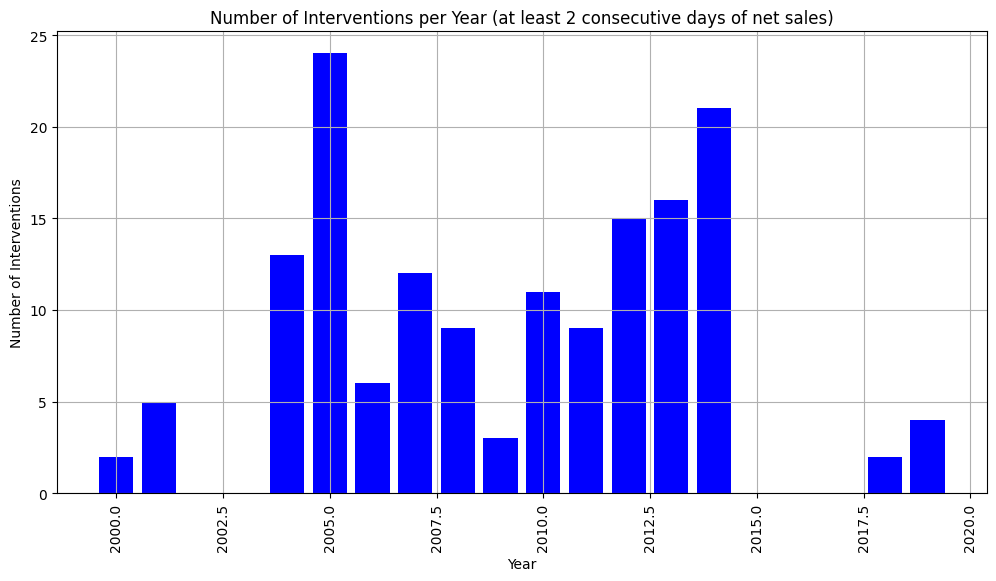

In [24]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Sort the data by date
colombia_data = colombia_data.sort_values(by='Date')

# Define a treatment period as at least 2 consecutive days of net sales (net < 0)
colombia_data['net_negative'] = colombia_data['net'] < 0

# Create a column to mark the end of consecutive intervention periods
colombia_data['shift_net_negative'] = colombia_data['net_negative'].shift(1, fill_value=False)
colombia_data['end_of_intervention'] = (colombia_data['net_negative'] != colombia_data['shift_net_negative']) & ~colombia_data['net_negative']

# Create a column to group consecutive intervention periods
colombia_data['intervention_group'] = colombia_data['end_of_intervention'].cumsum()

# Filter to keep only groups where the intervention is for at least 2 consecutive days
intervention_counts = colombia_data.groupby('intervention_group')['net_negative'].sum()
valid_interventions = intervention_counts[intervention_counts >= 2].index

# Mark valid treatment periods
colombia_data['treatment'] = colombia_data['intervention_group'].isin(valid_interventions) & colombia_data['net_negative']

# Extract the year from the 'Date' column
colombia_data['Year'] = colombia_data['Date'].dt.year

# Count the number of unique intervention groups per year
interventions_per_year = colombia_data[colombia_data['treatment']].groupby('Year')['intervention_group'].nunique().reset_index()
interventions_per_year.columns = ['Year', 'Intervention_Count']

# Plot the number of interventions per year
plt.figure(figsize=(12, 6))
plt.bar(interventions_per_year['Year'], interventions_per_year['Intervention_Count'], color='blue')

plt.title('Number of Interventions per Year (at least 2 consecutive days of net sales)')
plt.xlabel('Year')
plt.ylabel('Number of Interventions')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### 5-Day Intervention Window

In [44]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Sort the data by date
colombia_data = colombia_data.sort_values(by='Date')

# Define a treatment period as at least 5 consecutive days of net sales (net < 0)
colombia_data['net_negative'] = colombia_data['net'] < 0

# Create a column to mark the end of consecutive intervention periods
colombia_data['shift_net_negative'] = colombia_data['net_negative'].shift(1, fill_value=False)
colombia_data['end_of_intervention'] = (colombia_data['net_negative'] != colombia_data['shift_net_negative']) & ~colombia_data['net_negative']

# Create a column to group consecutive intervention periods
colombia_data['intervention_group'] = colombia_data['end_of_intervention'].cumsum()

# Filter to keep only groups where the intervention is for at least 5 consecutive days
intervention_counts = colombia_data.groupby('intervention_group')['net_negative'].sum()
valid_interventions = intervention_counts[intervention_counts >= 5].index

# Mark valid treatment periods
colombia_data['treatment'] = colombia_data['intervention_group'].isin(valid_interventions) & colombia_data['net_negative']

# Clean up intermediate columns
colombia_data = colombia_data.drop(columns=['net_negative', 'shift_net_negative', 'end_of_intervention', 'intervention_group'])

# Display the result
colombia_data[colombia_data['treatment']].head(20)

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/1222995516.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/1222995516.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']


,Date,Type,Purchases,Sales,Intervention,tipo,country,imports,exports,night_rate,tpm,pi,ExRate,embi,net,treatment
27526,2004-10-19,Discretionary,0.0,2.000,1,4,COL,4.25,1395.5,6.994,0.481615,-0.025232,6.5,1352.0,-2.000,True
27548,2004-10-20,Discretionary,0.0,1.250,1,4,COL,4.25,1395.5,6.994,0.481615,-0.396812,6.5,1352.0,-1.250,True
27570,2004-10-21,Discretionary,0.0,9.000,1,4,COL,4.25,1395.5,6.994,0.481615,0.275459,6.5,1352.0,-9.000,True
27592,2004-10-22,Discretionary,0.0,25.200,1,4,COL,4.25,1395.5,6.994,0.481615,-0.378927,6.5,1352.0,-25.200,True
27614,2004-10-25,Discretionary,0.0,12.150,1,4,COL,4.25,1395.5,6.994,0.481615,-0.156066,6.5,1352.0,-12.150,True
27636,2004-10-26,Discretionary,0.0,2.750,1,4,COL,4.25,1395.5,6.994,0.481615,0.856913,6.5,1352.0,-2.750,True
27658,2004-10-27,Discretionary,0.0,4.800,1,4,COL,4.25,1395.5,6.994,0.481615,0.804656,6.5,1352.0,-4.800,True
27680,2004-10-28,Discretionary,0.0,0.500,1,4,COL,4.25,1395.5,6.994,0.481615,-0.187056,6.5,1352.0,-0.500,True
27790,2004-11-04,Discretionary,0.0,59.450,1,4,COL,4.25,1395.5,6.997,0.481615,-0.420422,6.5,1352.0,-59.450,True
27812,2004-11-05,Discretionary,0.0,28.150,1,4,COL,4.25,1395.5,6.997,0.481615,-0.660963,6.5,1352.0,-28.150,True


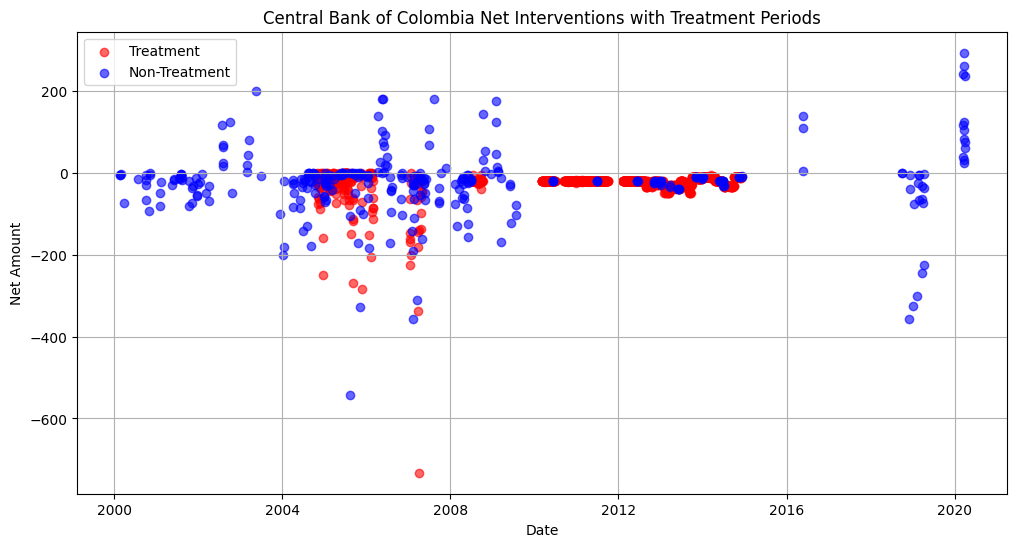

In [45]:
# Filter out rows where net intervention is zero
filtered_data = colombia_data[colombia_data['net'] != 0]

# Plot the net interventions, differentiating between treatment and non-treatment periods
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data[filtered_data['treatment']]['Date'], filtered_data[filtered_data['treatment']]['net'], label='Treatment', color='red', alpha=0.6)
plt.scatter(filtered_data[~filtered_data['treatment']]['Date'], filtered_data[~filtered_data['treatment']]['net'], label='Non-Treatment', color='blue', alpha=0.6)

plt.title('Central Bank of Colombia Net Interventions with Treatment Periods')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/3498604466.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/3498604466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']


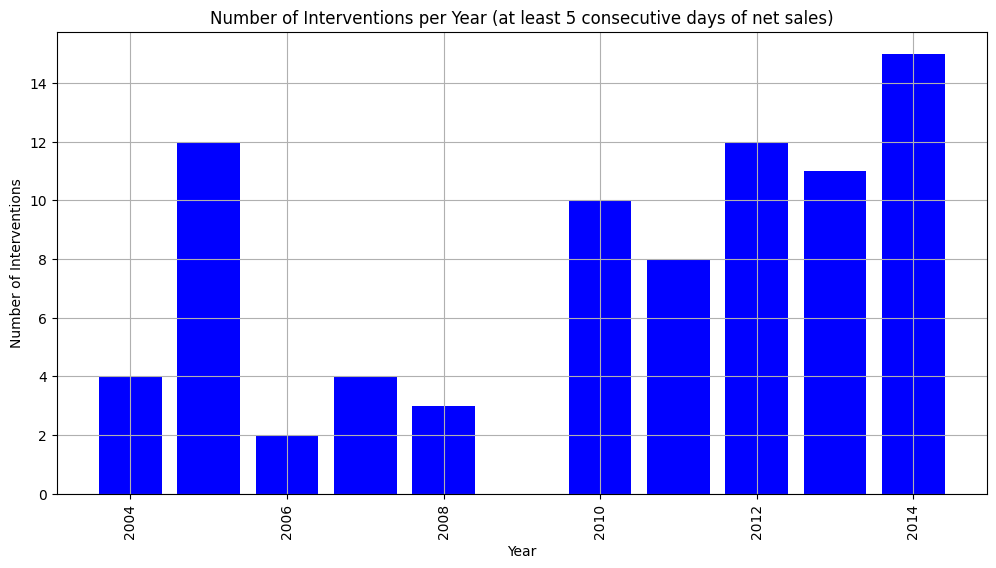

In [46]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Sort the data by date
colombia_data = colombia_data.sort_values(by='Date')

# Define a treatment period as at least 2 consecutive days of net sales (net < 0)
colombia_data['net_negative'] = colombia_data['net'] < 0

# Create a column to mark the end of consecutive intervention periods
colombia_data['shift_net_negative'] = colombia_data['net_negative'].shift(1, fill_value=False)
colombia_data['end_of_intervention'] = (colombia_data['net_negative'] != colombia_data['shift_net_negative']) & ~colombia_data['net_negative']

# Create a column to group consecutive intervention periods
colombia_data['intervention_group'] = colombia_data['end_of_intervention'].cumsum()

# Filter to keep only groups where the intervention is for at least 5 consecutive days
intervention_counts = colombia_data.groupby('intervention_group')['net_negative'].sum()
valid_interventions = intervention_counts[intervention_counts >= 5].index

# Mark valid treatment periods
colombia_data['treatment'] = colombia_data['intervention_group'].isin(valid_interventions) & colombia_data['net_negative']

# Extract the year from the 'Date' column
colombia_data['Year'] = colombia_data['Date'].dt.year

# Count the number of unique intervention groups per year
interventions_per_year = colombia_data[colombia_data['treatment']].groupby('Year')['intervention_group'].nunique().reset_index()
interventions_per_year.columns = ['Year', 'Intervention_Count']

# Plot the number of interventions per year
plt.figure(figsize=(12, 6))
plt.bar(interventions_per_year['Year'], interventions_per_year['Intervention_Count'], color='blue')

plt.title('Number of Interventions per Year (at least 5 consecutive days of net sales)')
plt.xlabel('Year')
plt.ylabel('Number of Interventions')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### 10-Day Intervention Windows

In [47]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Sort the data by date
colombia_data = colombia_data.sort_values(by='Date')

# Define a treatment period as at least 5 consecutive days of net sales (net < 0)
colombia_data['net_negative'] = colombia_data['net'] < 0

# Create a column to mark the end of consecutive intervention periods
colombia_data['shift_net_negative'] = colombia_data['net_negative'].shift(1, fill_value=False)
colombia_data['end_of_intervention'] = (colombia_data['net_negative'] != colombia_data['shift_net_negative']) & ~colombia_data['net_negative']

# Create a column to group consecutive intervention periods
colombia_data['intervention_group'] = colombia_data['end_of_intervention'].cumsum()

# Filter to keep only groups where the intervention is for at least 10 consecutive days
intervention_counts = colombia_data.groupby('intervention_group')['net_negative'].sum()
valid_interventions = intervention_counts[intervention_counts >= 10].index

# Mark valid treatment periods
colombia_data['treatment'] = colombia_data['intervention_group'].isin(valid_interventions) & colombia_data['net_negative']

# Clean up intermediate columns
colombia_data = colombia_data.drop(columns=['net_negative', 'shift_net_negative', 'end_of_intervention', 'intervention_group'])

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/3739313144.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/3739313144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']


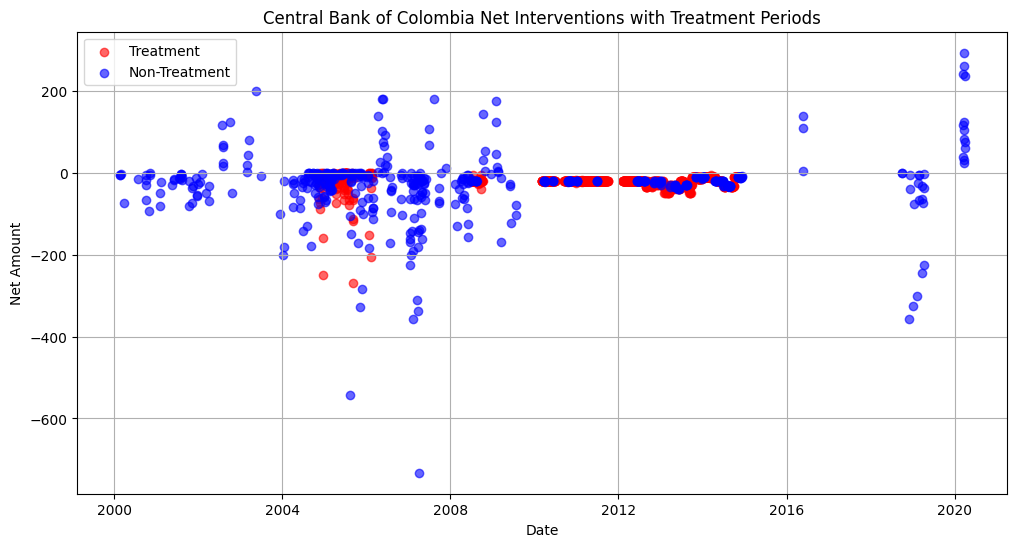

In [48]:
# Filter out rows where net intervention is zero
filtered_data = colombia_data[colombia_data['net'] != 0]

# Plot the net interventions, differentiating between treatment and non-treatment periods
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data[filtered_data['treatment']]['Date'], filtered_data[filtered_data['treatment']]['net'], label='Treatment', color='red', alpha=0.6)
plt.scatter(filtered_data[~filtered_data['treatment']]['Date'], filtered_data[~filtered_data['treatment']]['net'], label='Non-Treatment', color='blue', alpha=0.6)

plt.title('Central Bank of Colombia Net Interventions with Treatment Periods')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2088306063.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')
/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2088306063.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']


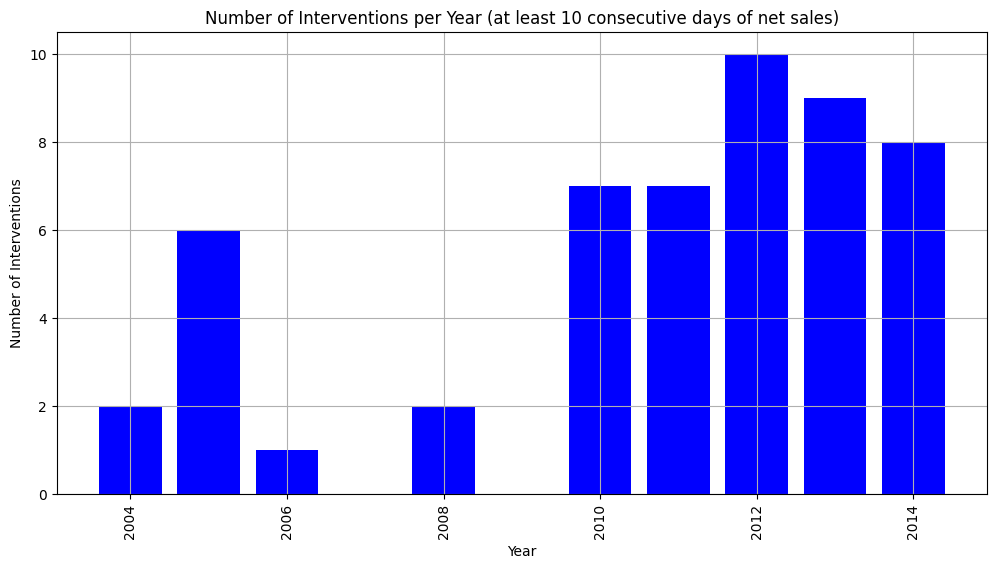

In [41]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Calculate the net intervention
colombia_data['net'] = colombia_data['Purchases'] - colombia_data['Sales']

# Sort the data by date
colombia_data = colombia_data.sort_values(by='Date')

# Define a treatment period as at least 2 consecutive days of net sales (net < 0)
colombia_data['net_negative'] = colombia_data['net'] < 0

# Create a column to mark the end of consecutive intervention periods
colombia_data['shift_net_negative'] = colombia_data['net_negative'].shift(1, fill_value=False)
colombia_data['end_of_intervention'] = (colombia_data['net_negative'] != colombia_data['shift_net_negative']) & ~colombia_data['net_negative']

# Create a column to group consecutive intervention periods
colombia_data['intervention_group'] = colombia_data['end_of_intervention'].cumsum()

# Filter to keep only groups where the intervention is for at least 10 consecutive days
intervention_counts = colombia_data.groupby('intervention_group')['net_negative'].sum()
valid_interventions = intervention_counts[intervention_counts >= 10].index

# Mark valid treatment periods
colombia_data['treatment'] = colombia_data['intervention_group'].isin(valid_interventions) & colombia_data['net_negative']

# Extract the year from the 'Date' column
colombia_data['Year'] = colombia_data['Date'].dt.year

# Count the number of unique intervention groups per year
interventions_per_year = colombia_data[colombia_data['treatment']].groupby('Year')['intervention_group'].nunique().reset_index()
interventions_per_year.columns = ['Year', 'Intervention_Count']

# Plot the number of interventions per year
plt.figure(figsize=(12, 6))
plt.bar(interventions_per_year['Year'], interventions_per_year['Intervention_Count'], color='blue')

plt.title('Number of Interventions per Year (at least 10 consecutive days of net sales)')
plt.xlabel('Year')
plt.ylabel('Number of Interventions')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

## Interventions: Just Sales

/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/3724616104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')


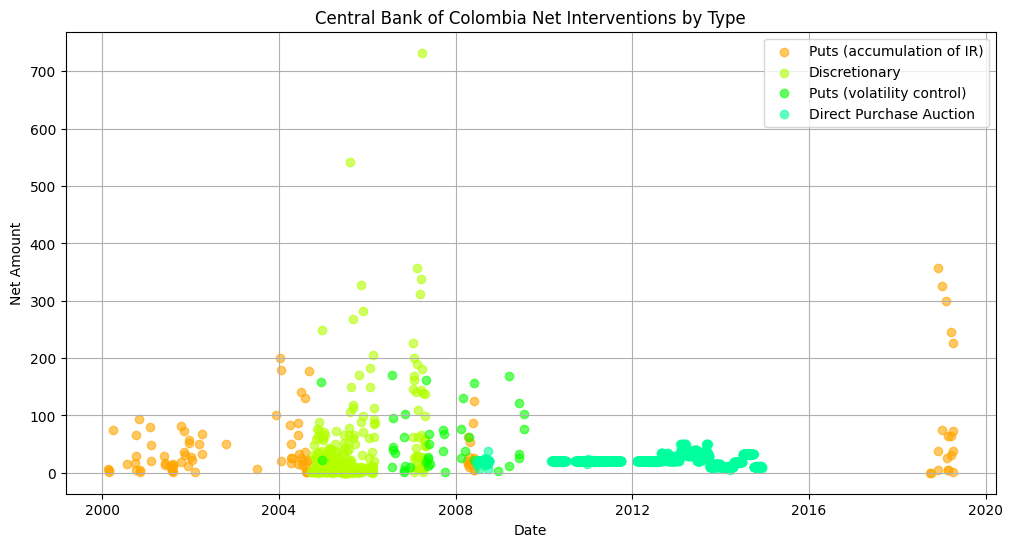

In [52]:
import seaborn as sns

# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')

# Extract rows where there was an intervention
interventions = colombia_data[colombia_data['Intervention'] != 0]

# Set up the color palette
palette = sns.color_palette("hsv", len(interventions['Type'].unique()))

# Exclude Purchases = 0
interventions = interventions[interventions['Sales'] != 0]

# Plot the net interventions for the entire period, colored by type
plt.figure(figsize=(12, 6))
for intervention_type, color in zip(interventions['Type'].unique(), palette):
    subset = interventions[interventions['Type'] == intervention_type]
    plt.scatter(subset['Date'], subset['Sales'], label=intervention_type, color=color, alpha=0.6)

plt.title('Central Bank of Colombia Net Interventions by Type')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.legend()
plt.grid(True)
plt.show()

### 10-Day Intervention Window

In [64]:
# Filter the dataset for Colombia
colombia_data = df[df['country'] == 'COL']

# Convert the 'Date' column to datetime format
colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')


# Sort the data by date
colombia_data = colombia_data.sort_values(by='Date')

# Define a treatment period as at least 2 consecutive days of net sales (net < 0)
colombia_data['sales_positive'] = colombia_data['Sales'] > 0

# Create a column to mark the end of consecutive intervention periods
colombia_data['shift_sales_positive'] = colombia_data['sales_positive'].shift(1, fill_value=False)
colombia_data['end_of_intervention'] = (colombia_data['sales_positive'] != colombia_data['shift_sales_positive']) & ~colombia_data['sales_positive']

# Create a column to group consecutive intervention periods
colombia_data['intervention_group'] = colombia_data['end_of_intervention'].cumsum()

# Filter to keep only groups where the intervention is for at least 2 consecutive days
intervention_counts = colombia_data.groupby('intervention_group')['sales_positive'].sum()
valid_interventions = intervention_counts[intervention_counts >= 10].index

# Mark valid treatment periods
colombia_data['treatment'] = colombia_data['intervention_group'].isin(valid_interventions) & colombia_data['sales_positive']

# Clean up intermediate columns
colombia_data = colombia_data.drop(columns=['sales_positive', 'shift_sales_positive', 'end_of_intervention', 'intervention_group'])


/var/folders/4q/634d8_qs2qdd58rzydjvszzm0000gn/T/ipykernel_6316/2856554069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colombia_data['Date'] = pd.to_datetime(colombia_data['Date'], format='%Y-%m-%d', errors='coerce')


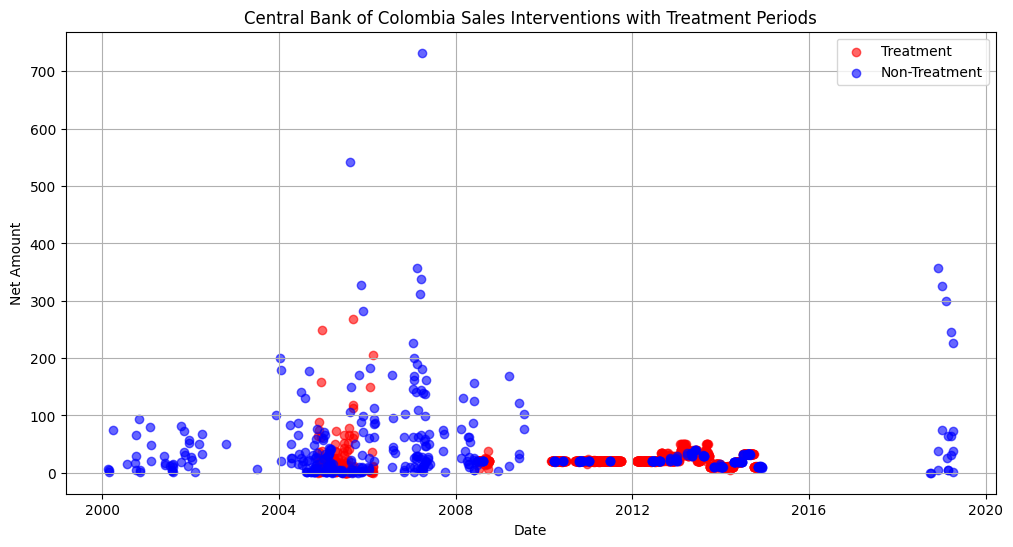

In [65]:
# Filter out rows where net intervention is zero
filtered_data = colombia_data[colombia_data['Sales'] != 0]

# Plot the net interventions, differentiating between treatment and non-treatment periods
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data[filtered_data['treatment']]['Date'], filtered_data[filtered_data['treatment']]['Sales'], label='Treatment', color='red', alpha=0.6)
plt.scatter(filtered_data[~filtered_data['treatment']]['Date'], filtered_data[~filtered_data['treatment']]['Sales'], label='Non-Treatment', color='blue', alpha=0.6)

plt.title('Central Bank of Colombia Net Interventions with Treatment Periods')
plt.xlabel('Date')
plt.ylabel('Net Amount')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Keep columns
keep = ['Date', 'country', 'treatment']

Filtered = filtered_data[keep]

In [68]:
# Merge Back to main df
df = pd.merge(df, Filtered, on=['Date', 'country'], how='left')

In [69]:
# Turn Treatment variable into 1 if TRUE, 0 if FALSE or NaN
df['treatment'] = df['treatment'].apply(lambda x: 1 if x == True else 0)

In [70]:
# Export as csv
df.to_csv('/Users/edmundoarias/Documents/Uniandes/2024-10/HE 2/FX-Intervention/8._Extension Final/2._ProcessedData/Long/FinalData.csv', index=False)